# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

In [ ]:
# Install dependencies
!pip install -U sentence-transformers -q
!pip install datasets -q
!pip install faiss-cpu -q
!pip install -U transformers -q
!pip install tensorflow -q

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = 'drive/MyDrive/COMP90042_Project/'
MODEL_DIR =  DIR + 'model/'
RESULT_DIR = DIR + 'result/'
DATA =  DIR + 'data/'

import random
random.seed(42)
RANDOM_SAMPLE = random.randint(0, 1200)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json

DATA_DIR = DATA

class Data:
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = data_dir

        # load raw JSON
        self.train_data = self.load_data(os.path.join(self.data_dir, 'raw', 'train-claims.json'))
        self.dev_data   = self.load_data(os.path.join(self.data_dir, 'raw', 'dev-claims.json'))
        self.test_data  = self.load_data(os.path.join(self.data_dir, 'raw', 'test-claims-unlabelled.json'))
        self.evidence       = self.load_data(os.path.join(self.data_dir, 'raw', 'evidence.json'))
        self.retrieved_evidences = self.load_data(os.path.join(self.data_dir, 'retrieved_evidences.json'))

    def load_data(self, filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)

    def __str__(self):
        return (
            f'Number of train claims: {len(self.train_data)}\n'
            f'Number of dev   claims: {len(self.dev_data)}\n'
            f'Number of test  claims: {len(self.test_data)}\n'
            f'Number of evidences: {len(self.evidence)}\n'
            f'Number of retrieved evidences: {len(self.retrieved_evidences)}'
        )

In [ ]:
data = Data()
print(data)

Number of train claims: 1228
Number of dev   claims: 154
Number of test  claims: 153
Number of evidences: 1208827
Number of retrieved evidences: 154


In [ ]:
print(list(data.train_data.values())[RANDOM_SAMPLE])
print(list(data.test_data.values())[0])

{'claim_text': '"An article in Science magazine illustrated that a rise in carbon dioxide did not precede a rise in temperatures, but actually lagged behind temperature rises by 200 to 1000 years.', 'claim_label': 'DISPUTED', 'evidences': ['evidence-217862', 'evidence-705706']}
{'claim_text': 'The contribution of waste heat to the global climate is 0.028 W/m2.'}


In [ ]:
def build_dataset(data, evidence, retrieved_evidences=None, dev=False):
  texts, labels = [], []
  for item in data:
    claim = data[item]['claim_text']
    if dev == False:
      ev_texts = ' '.join(evidence[eid] for eid in data[item]['evidences'])
    else:
      ev_texts = ' '.join(evidence[eid] for eid in retrieved_evidences[item])
    texts.append(claim + ' ' + ev_texts)
    labels.append(data[item]['claim_label'])
  return texts, labels

train_texts, train_labels = build_dataset(data.train_data, data.evidence)
dev_texts, dev_labels = build_dataset(data.dev_data, data.evidence, data.retrieved_evidences, dev =True)
print(train_texts[RANDOM_SAMPLE])
print(train_labels[RANDOM_SAMPLE])
print(dev_texts[0])
print(dev_labels[0])

"An article in Science magazine illustrated that a rise in carbon dioxide did not precede a rise in temperatures, but actually lagged behind temperature rises by 200 to 1000 years. Studies of the Vostok ice core show that at the "beginning of the deglaciations, the CO 2 increase either was in phase or lagged by less than ~1000 years with respect to the Antarctic temperature, whereas it clearly lagged behind the temperature at the onset of the glaciations". Recent warming is followed by carbon dioxide levels with only a 5 months delay.
DISPUTED
[South Australia] has the most expensive electricity in the world. [citation needed] South Australia has the highest retail price for electricity in the country. Energy in Australia is the production in Australia of energy and electricity, for consumption or export. "South Australia has the highest power prices in the world". Industrialised countries such as Canada, the US, and Australia are among the highest per capita consumers of electricity i

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

# integer sequences and padding
train_seq = tokenizer.texts_to_sequences(train_texts)
dev_seq = tokenizer.texts_to_sequences(dev_texts)
max_seq_len = 100
X_train = pad_sequences(train_seq, maxlen=max_seq_len)
X_dev = pad_sequences(dev_seq, maxlen=max_seq_len)

# encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_dev = label_encoder.transform(dev_labels)
num_classes = len(label_encoder.classes_)
y_train = np.eye(num_classes)[y_train]
y_dev = np.eye(num_classes)[y_dev]

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential


vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 100

model = Sequential([
    Input(shape=(max_seq_len,)),
    Embedding(vocab_size, embedding_dim),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,764 (4.29 MB)

 Trainable params: 1,125,764 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils import class_weight
batch_size = 32
epochs = 10

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(monitor='val_loss', patience=3)



y_integers = label_encoder.transform(train_labels)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.arange(num_classes),
    y=y_integers
)
cw_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    batch_size=batch_size,
    epochs=epochs,
    class_weight=cw_dict,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3555 - loss: 1.3529

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.3556 - loss: 1.3538 - val_accuracy: 0.1818 - val_loss: 1.3878
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 319ms/step - accuracy: 0.3635 - loss: 1.3641 - val_accuracy: 0.3766 - val_loss: 1.4177
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.4704 - loss: 1.2331 - val_accuracy: 0.1104 - val_loss: 1.5527
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 528ms/step - accuracy: 0.4761 - loss: 1.1540 - val_accuracy: 0.1623 - val_loss: 1.7429


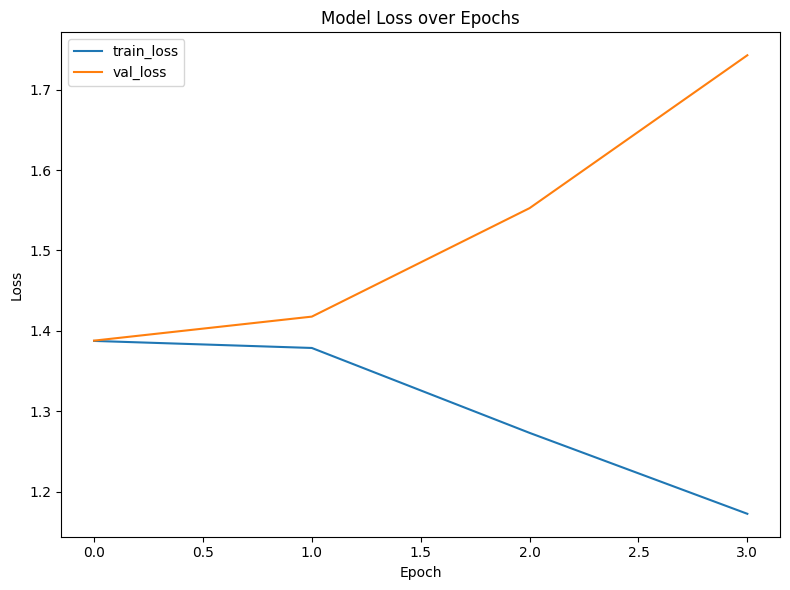

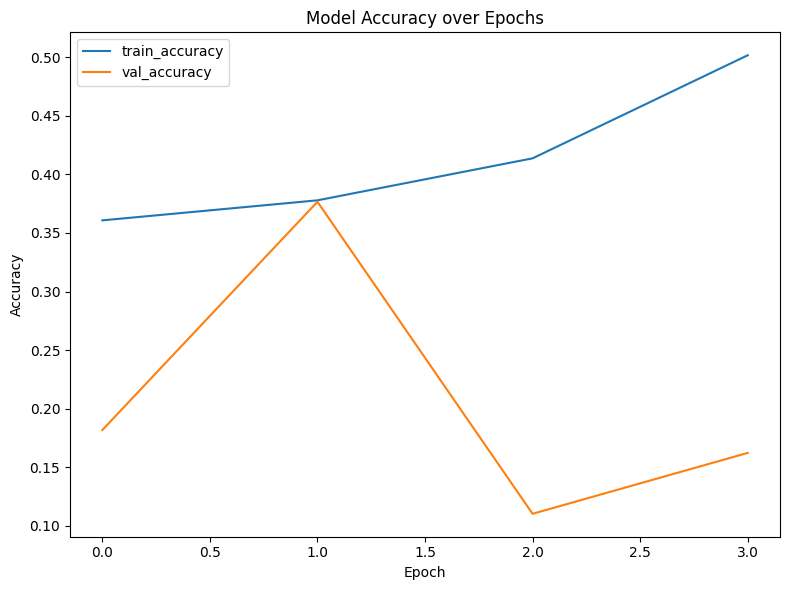

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Load best model and predict
model = load_model('best_model.h5')
y_pred = model.predict(X_dev)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_dev, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step


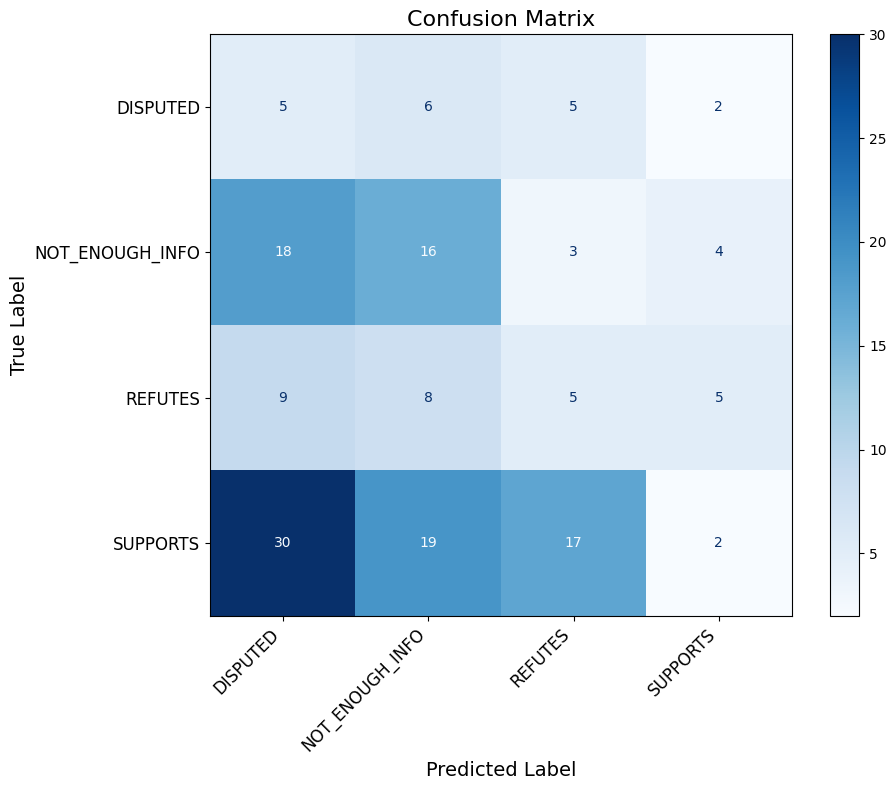

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=True)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

ax.set_title("Confusion Matrix", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)

plt.tight_layout()
plt.show()

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
predictions = {}
for item, pred_cls in zip(data.dev_data, y_pred_classes):

    predictions[item] = {
        "claim_text": data.dev_data[item]["claim_text"],
        "claim_label": label_encoder.classes_[pred_cls],
        "evidences": data.retrieved_evidences[item]
    }
with open('dev-predictions.json', 'w') as f:
    json.dump(predictions, f, indent=4)

In [ ]:
# run pyton in code from google drive
!python /content/drive/MyDrive/COMP90042_Project/eval.py --predictions dev-predictions.json --groundtruth /content/drive/MyDrive/COMP90042_Project/data/raw/dev-claims-baseline.json


Evidence Retrieval F-score (F)    = 0.05257462832902099
Claim Classification Accuracy (A) = 0.2662337662337662
Harmonic Mean of F and A          = 0.0878091138570636


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*